In [60]:
# Import the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler


In [42]:
population_df = pd.read_csv("population_by_year_2014_2024.csv")
meat_df = pd.read_csv("Consumption of meat per capita.csv")

In [43]:
population_df = population_df.drop(columns= ['2022', '2023', '2024'])
population_df.head()

,Country,2014,2015,2016,2017,2018,2019,2020,2021
0,Afghanistan,56805036,58070279,59363704,60685938,62037623,63419415,64831984,66276015
1,Albania,127571863,129443136,131341857,133268430,135223262,137206769,139219371,141261494
2,Algeria,147582820,151776865,156090098,160525905,165087770,169779276,174604106,179566049
3,Andorra,133274038,134398607,135532666,136676293,137829571,138992580,140165403,141348122
4,Angola,35838921,36323701,36815040,37313024,37817745,38329292,38847760,39373240


In [44]:
meat_df = meat_df[meat_df['Year'] >= 2014]
meat_df.head()

,Entity,Year,Poultry,Beef,Sheep and goat,Pork,Other meats,Fish and seafood
53,Afghanistan,2014,2.11,4.989999,5.059999,0.03,0.43,0.19
54,Afghanistan,2015,1.96,3.810000,4.770000,0.02,0.36,0.21
55,Afghanistan,2016,2.00,3.280000,4.800000,0.01,0.36,0.23
56,Afghanistan,2017,1.79,2.920000,4.450000,0.02,0.33,0.43
57,Afghanistan,2018,1.46,2.670000,4.319999,0.03,0.32,0.42


In [45]:
population_long = pd.melt(population_df, id_vars=["Country"],
                          var_name="Year", value_name="Population")
population_long.rename(columns={"Country": "Entity"}, inplace=True)
population_long["Year"] = pd.to_numeric(population_long["Year"])
population_long.head(500)

,Entity,Year,Population
0,Afghanistan,2014,56805036
1,Albania,2014,127571863
2,Algeria,2014,147582820
3,Andorra,2014,133274038
4,Angola,2014,35838921
...,...,...,...
495,Micronesia,2016,61844204
496,Moldova,2016,139568745
497,Monaco,2016,92573003
498,Mongolia,2016,50258012


In [46]:
population_long["Year"] = pd.to_numeric(population_long["Year"], errors='coerce')
meat_df["Year"] = pd.to_numeric(meat_df["Year"], errors='coerce')
combined_df = pd.merge(population_long, meat_df, on=["Entity", "Year"], how="inner")
combined_df.head()

,Entity,Year,Population,Poultry,Beef,Sheep and goat,Pork,Other meats,Fish and seafood
0,Afghanistan,2014,56805036,2.110000,4.989999,5.059999,0.030000,0.430000,0.190000
1,Albania,2014,127571863,11.830000,13.550000,8.580000,6.750000,0.000000,7.760001
2,Algeria,2014,147582820,7.810001,6.240000,7.790001,0.000000,0.380000,4.410000
3,Angola,2014,35838921,15.500000,6.950000,0.870000,11.010000,0.370000,24.450000
4,Antigua and Barbuda,2014,133170466,61.161774,11.368471,1.929740,7.898938,0.409945,54.632652


In [47]:
features = ['Year', 'Poultry', 'Beef', 'Sheep and goat', 'Other meats', 'Fish and seafood']
target = 'Pork'

# Remove rows with missing values
df_clean = combined_df.dropna(subset=features + [target])
X = df_clean[features]
y = df_clean[target]
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initialize and train Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
# Train model
gb_model.fit(X_train_scaled, y_train)
# Make predictions
y_pred = gb_model.predict(X_test_scaled)



In [49]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

Model Performance Metrics:
MSE: 33.3416
RMSE: 5.7742
MAE: 3.6073
R2 Score: 0.8409


In [50]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [51]:
# Print best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Score:", np.sqrt(-grid_search.best_score_))


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 6.309719753665989


In [52]:
# Train final model with best parameters
best_gb = grid_search.best_estimator_
best_pred = best_gb.predict(X_test_scaled)

In [53]:
# Calculate final metrics
final_mse = mean_squared_error(y_test, best_pred)
final_r2 = r2_score(y_test, best_pred)
print("\nFinal Model Performance:")
print(f"MSE: {final_mse:.4f}")
print(f"R2 Score: {final_r2:.4f}")


Final Model Performance:
MSE: 21.4581
R2 Score: 0.8976


In [57]:
# Feature importance plot
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'feature': features,
    'importance': best_gb.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=True)
importance_df

,feature,importance
0,Year,0.008465
4,Other meats,0.096098
3,Sheep and goat,0.147399
2,Beef,0.166705
5,Fish and seafood,0.175508
1,Poultry,0.405825


<Figure size 1000x600 with 0 Axes>

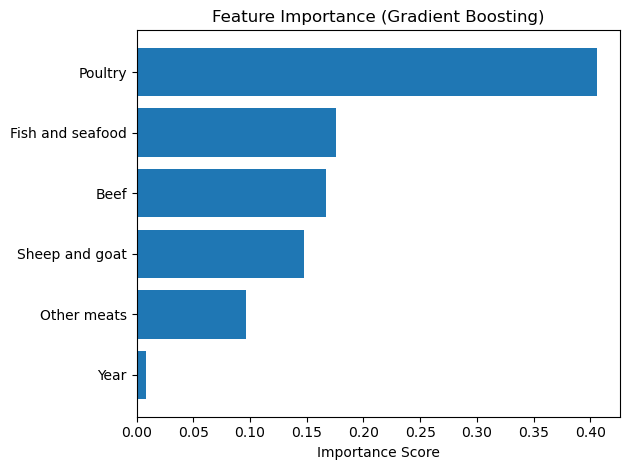

In [58]:
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance (Gradient Boosting)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

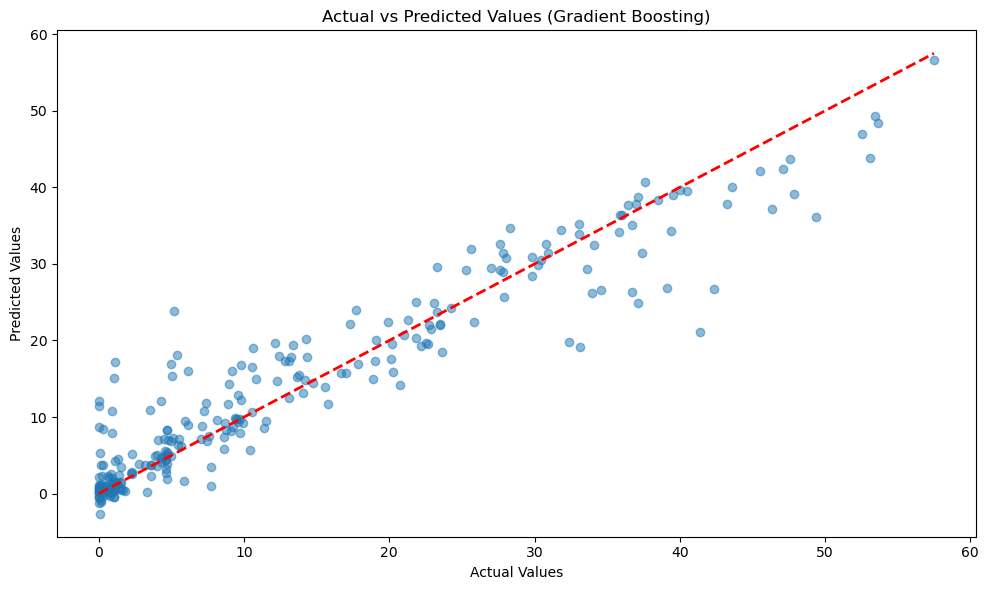

In [59]:
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Gradient Boosting)')
plt.tight_layout()
plt.show()

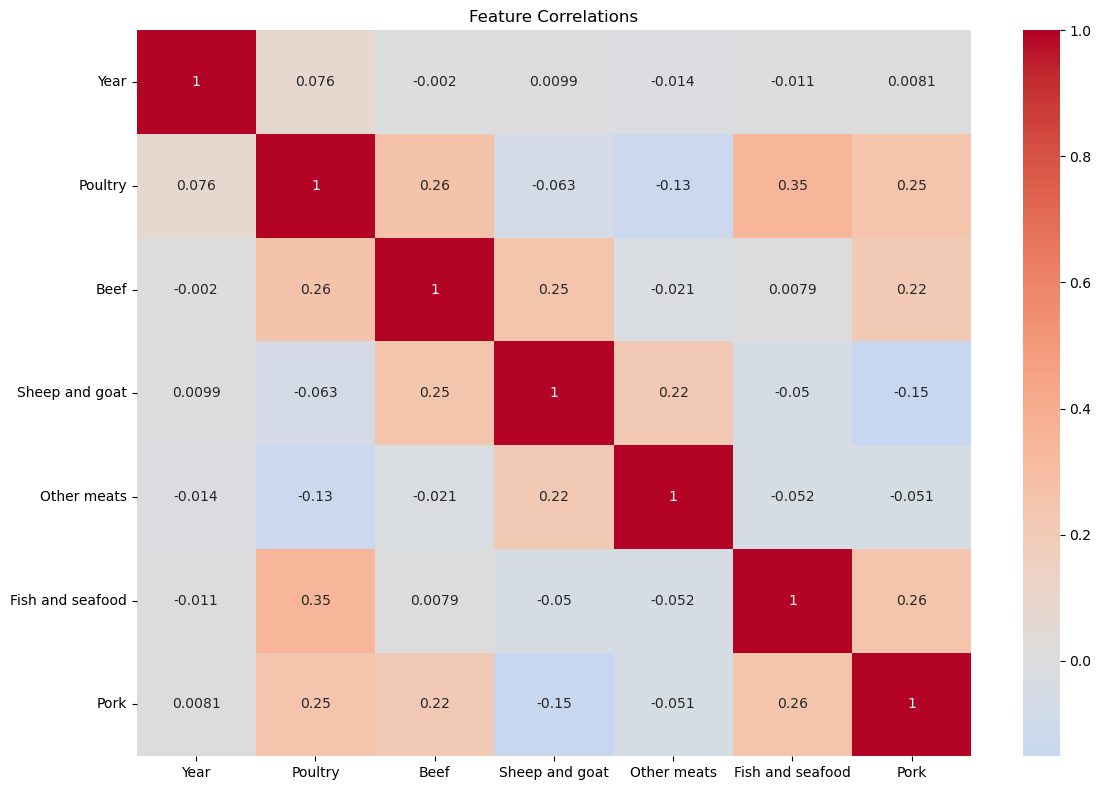

In [61]:
# Additional analysis: Feature correlations
plt.figure(figsize=(12, 8))
correlation_matrix = df_clean[features + [target]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()